In [1]:
# Get parent directory and add to sys.path
import os; import sys
import numpy as np
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
# MPC import
from Deliverable_5_2.LinearMPC_t.MPCVelControl import MPCVelControl

from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis, plot_static_states_inputs

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [3]:
Ts = 0.05
sim_time = 20; H = 5.0
x0 = np.array([0, 0, 0, 0, 0, 0, 5, 5, 10, 0, 0, 1])  # initial state
x_target = np.zeros((12,))

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

# Static mass change and zero fuel rate
rocket.mass = 2.0
rocket.fuel_rate = 0.1
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(mpc, sim_time, H, x0, x_target=x_target, method='nonlinear')

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl, Ref=ref[:,:-1], T_ol=t_ol[...,:-1], X_ol=x_ol, U_ol=u_ol); 


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Simulating time 0.00: 
[zvel MPC step]
[measurement]
  vz_meas        =  10.0000
  vz_trim        =  0.0000
  dx_meas        =  10.0000
[observer]
  dx_hat (est)   =  10.0000
  d_hat  (est)   =  0.0000
  du_prev        =  0.0000
[reference]
  vz_target_abs  =  0.0000
[steady-state target]
  dxs (state ss) =  0.0000
  dus (input ss) = -0.0000
[mpc initial condition]
  dX0            =  10.0000
[mpc output]
  du_cmd         = -26.5667
  u_cmd (abs)    =  40.1000
-------------------------------
Fuel left: 1.00 kg, 
Simulating time 0.05: 
[zvel MPC step]
[measurement]
  vz_meas        =  9.7860
  vz_trim      

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=399, step=2), IntSlider(value=0…

 JS Error => error: Uncaught SyntaxError: Unexpected string


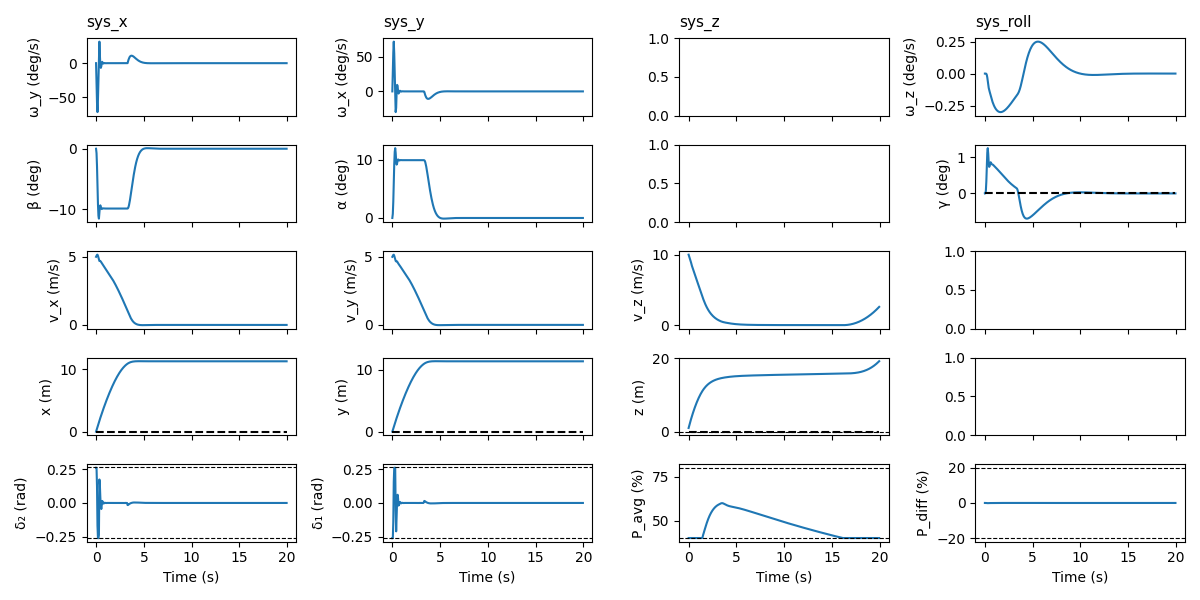

In [4]:
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, ref[:,:-1])

In [5]:
##################################

        # SIMU INFO

##################################
print("=== Simulation info ===")
print(f"Ts           = {Ts} s")
print(f"Horizon H    = {H} s ({int(H/Ts)} steps)")
print(f"Sim time     = {sim_time} s")
print(f"Method       = linear")
print("")



##################################

    # Input constraints INFO

##################################

print("=== Input constraints check ===")

print(f"d1   in [{np.rad2deg(u_cl[0,:].min()):.3f}, {np.rad2deg(u_cl[0,:].max()):.3f}]   (limit ±15°)")
print(f"d2   in [{np.rad2deg(u_cl[1,:].min()):.3f}, {np.rad2deg(u_cl[1,:].max()):.3f}]   (limit ±15°)")
print(f"Pavg in [{u_cl[2,:].min():.2f}, {u_cl[2,:].max():.2f}]   (limit [40,80])")
print(f"Pdif in [{u_cl[3,:].min():.2f}, {u_cl[3,:].max():.2f}]   (limit ±20)")
print("")


import numpy as np

alpha = np.rad2deg(x_cl[3, :])
beta  = np.rad2deg(x_cl[4, :])


##################################

    # Angle constraints INFO

##################################

print("=== Angle constraints check ===")
print(f"alpha max |α| = {np.abs(alpha).max():.2f} deg   (limit 10 deg)")
print(f"beta  max |β| = {np.abs(beta).max():.2f} deg   (limit 10 deg)")
print("")




=== Simulation info ===
Ts           = 0.05 s
Horizon H    = 5.0 s (100 steps)
Sim time     = 20 s
Method       = linear

=== Input constraints check ===
d1   in [-14.900, 14.900]   (limit ±15°)
d2   in [-14.900, 14.900]   (limit ±15°)
Pavg in [40.10, 59.90]   (limit [40,80])
Pdif in [-0.11, 0.06]   (limit ±20)

=== Angle constraints check ===
alpha max |α| = 11.96 deg   (limit 10 deg)
beta  max |β| = 11.57 deg   (limit 10 deg)



In [6]:
def settling_time(t, signal, tol=0.15):
    ref = 0.0
    err = np.abs(signal - ref)
    idx = np.where(err <= tol)[0]
    if len(idx) == 0:
        return None
    for k in idx:
        if np.all(err[k:] <= tol):
            return t[k]
    return None

def print_settling(name, t, sig, tol):
    ts = settling_time(t, sig, tol)
    if ts is None:
        print(f"{name} settling time: > {t[-1]:.2f} s (not settled)")
    else:
        print(f"{name} settling time: {ts:.2f} s")

##################################

    # Settling time INFO

##################################
print("=== Settling time ===")
print_settling("vx", t_cl, x_cl[6,:], tol=0.05)
print_settling("vy", t_cl, x_cl[7,:], tol=0.05)
print_settling("vz", t_cl, x_cl[8,:], tol=0.05)
print("")

Xf_x = mpc.mpc_x.Xf  # terminal set xvel
inside = [
    Xf_x.contains(x_cl[mpc.mpc_x.x_ids, k] - mpc.mpc_x.xs)
    for k in range(x_cl.shape[1])
]

first_inside = next((t_cl[k] for k,v in enumerate(inside) if v), None)

##################################

    # Terminal set entry INFO

##################################

print("=== Terminal set entry ===")
print(f"xvel enters Xf at t = {first_inside:.2f} s")
print("")


##################################

      # Trim values INFO

##################################

print("=== TRIM VALUES ===")

print("\n--- xvel ---")
print("xs_xvel =", mpc.mpc_x.xs)
print("us_xvel =", mpc.mpc_x.us)

print("\n--- yvel ---")
print("xs_yvel =", mpc.mpc_y.xs)
print("us_yvel =", mpc.mpc_y.us)

print("\n--- zvel ---")
print("xs_zvel =", mpc.mpc_z.xs)
print("us_zvel =", mpc.mpc_z.us)

print("\n--- roll ---")
print("xs_roll =", mpc.mpc_roll.xs)
print("us_roll =", mpc.mpc_roll.us)


=== Settling time ===
vx settling time: 4.30 s
vy settling time: 4.30 s
vz settling time: > 20.00 s (not settled)

=== Terminal set entry ===
xvel enters Xf at t = 3.25 s

=== TRIM VALUES ===

--- xvel ---
xs_xvel = [0. 0. 0.]
us_xvel = [0.]

--- yvel ---
xs_yvel = [0. 0. 0.]
us_yvel = [0.]

--- zvel ---
xs_zvel = [0.]
us_zvel = [66.66666667]

--- roll ---
xs_roll = [0. 0.]
us_roll = [0.]


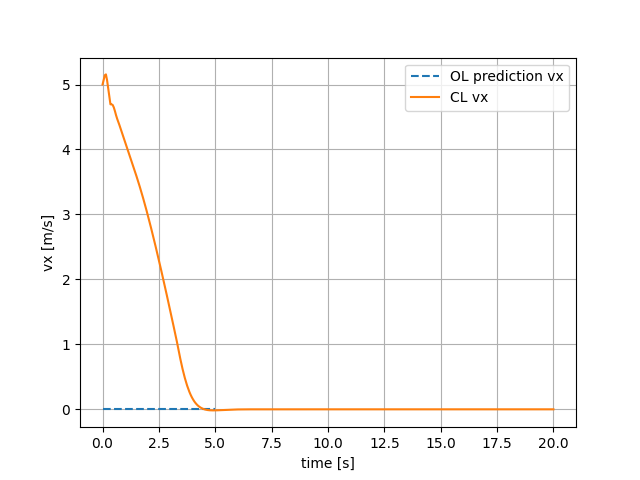

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t_ol[:,0], x_ol[2,:,0], '--', label="OL prediction vx")
plt.plot(t_cl, x_cl[6,:], label="CL vx")
plt.xlabel("time [s]")
plt.ylabel("vx [m/s]")
plt.legend()
plt.grid(True)


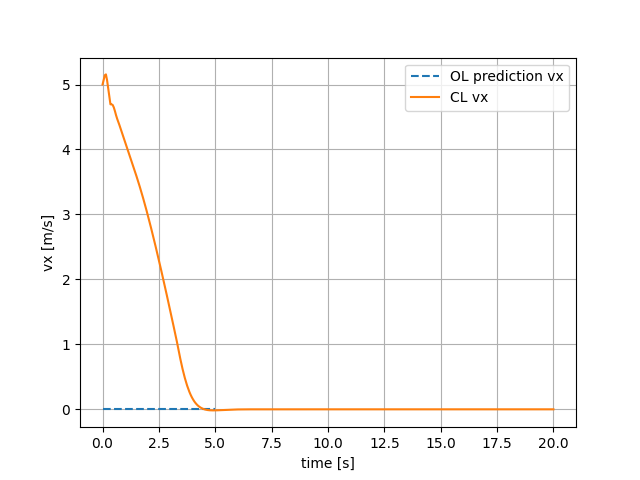

In [8]:
plt.figure()

# OL prediction at time k=0 (reconstructed)
vx_ol = mpc.mpc_x.xs[2] + x_ol[2,:,0]
plt.plot(t_ol[:,0], vx_ol, '--', label="OL prediction vx")

# CL trajectory
plt.plot(t_cl, x_cl[6,:], label="CL vx")

plt.xlabel("time [s]")
plt.ylabel("vx [m/s]")
plt.legend()
plt.grid(True)


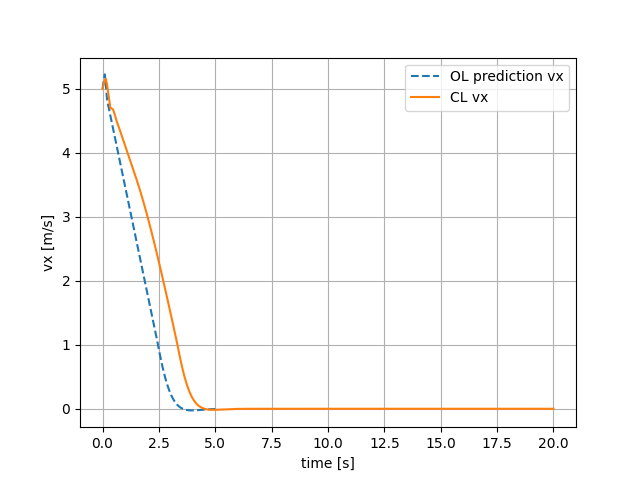

In [9]:
plt.figure()

# Open-loop prediction of vx at time k=0 (FULL state index!)
plt.plot(
    t_ol[:, 0],
    x_ol[6, :, 0],     # <-- index 6 = vx
    '--',
    label="OL prediction vx"
)

# Closed-loop vx
plt.plot(
    t_cl,
    x_cl[6, :],
    label="CL vx"
)

plt.xlabel("time [s]")
plt.ylabel("vx [m/s]")
plt.legend()
plt.grid(True)


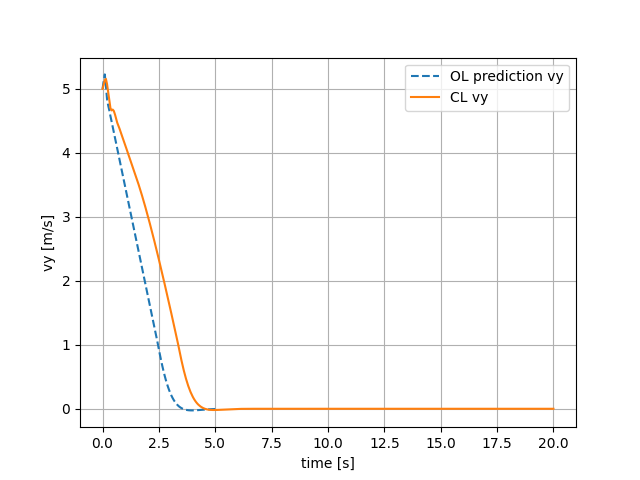

In [10]:
plt.figure()

# Open-loop prediction of vx at time k=0 (FULL state index!)
plt.plot(
    t_ol[:, 0],
    x_ol[7, :, 0],     # <-- index 6 = vx
    '--',
    label="OL prediction vy"
)

# Closed-loop vx
plt.plot(
    t_cl,
    x_cl[7, :],
    label="CL vy"
)

plt.xlabel("time [s]")
plt.ylabel("vy [m/s]")
plt.legend()
plt.grid(True)

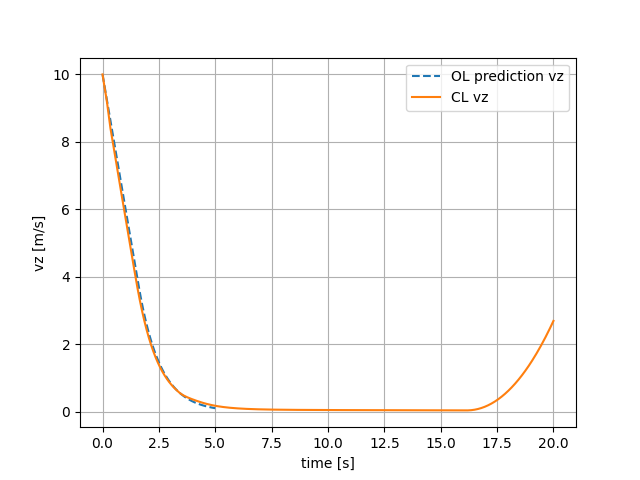

In [11]:
plt.figure()

# Open-loop prediction of vx at time k=0 (FULL state index!)
plt.plot(
    t_ol[:, 0],
    x_ol[8, :, 0],     # <-- index 6 = vx
    '--',
    label="OL prediction vz"
)

# Closed-loop vx
plt.plot(
    t_cl,
    x_cl[8, :],
    label="CL vz"
)

plt.xlabel("time [s]")
plt.ylabel("vz [m/s]")
plt.legend()
plt.grid(True)

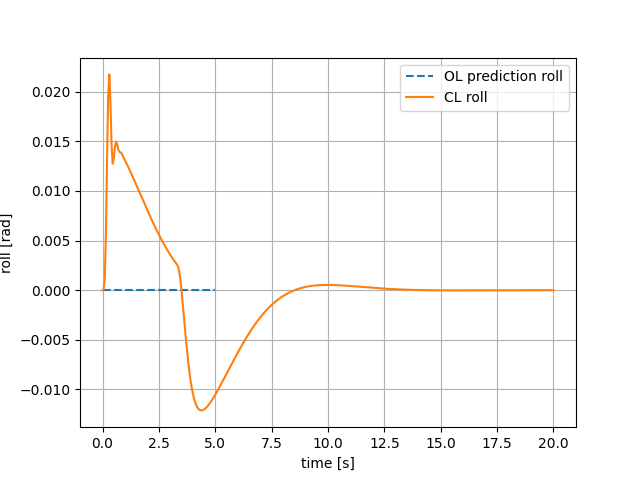

In [12]:
plt.figure()

# Open-loop prediction of vx at time k=0 (FULL state index!)
plt.plot(
    t_ol[:, 0],
    x_ol[5, :, 0],     # <-- index 6 = vx
    '--',
    label="OL prediction roll"
)

# Closed-loop vx
plt.plot(
    t_cl,
    x_cl[5, :],
    label="CL roll"
)

plt.xlabel("time [s]")
plt.ylabel("roll [rad]")
plt.legend()
plt.grid(True)

<>:7: SyntaxWarning: invalid escape sequence '\h'
<>:7: SyntaxWarning: invalid escape sequence '\h'
C:\Users\makss\AppData\Local\Temp\ipykernel_28820\1375503577.py:7: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("Estimated disturbance $\hat d$")


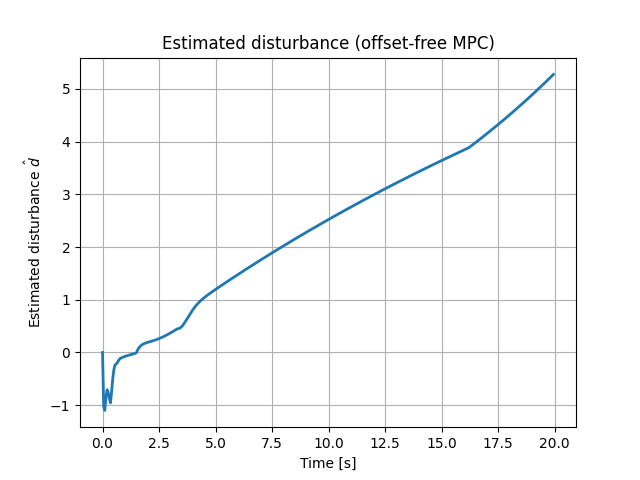

In [13]:
d_hat = np.array(mpc.mpc_z.d_hat_log)  # z-velocity MPC
t = t_cl[:len(d_hat)]

plt.figure()
plt.plot(t, d_hat, linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Estimated disturbance $\hat d$")
plt.title("Estimated disturbance (offset-free MPC)")
plt.grid(True)
plt.show()